goal : the highest returns possible within any given 10-hour period.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from collections import deque

import warnings
warnings.filterwarnings('ignore')

## Explore Dataset
* `timestamp`:
* `open`:
* `high`:
* `low`:
* `close`: price at the end of the minute
* `volume_btc`:
* `volume_currency`:
* `weighted_close`:
* Why should we use or not use `close` to calculate our returns?

In [2]:
# df = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
# df.columns = ['timestamp','open','high','low','close','volume_btc','volume_currency','weighted_close']
# df.head()

,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_close
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


As we can see, the first few years of Bitcoin is not so interesting so we will use the last 10,000 minutes as our validation set and the last 100,000 minutes (excluding validation set) as our training set.

<AxesSubplot:>

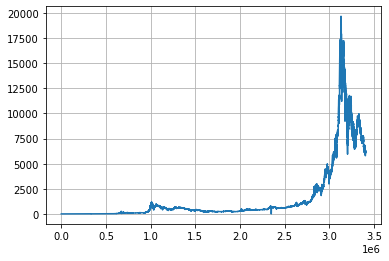

In [3]:
# df.close.plot(grid=True)

In [4]:
# train_df = df.iloc[-100000:-10000,:].copy()
# valid_df = df.iloc[-10000:,:].copy()

<AxesSubplot:>

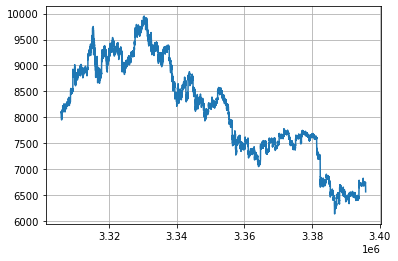

In [5]:
# train_df.close.plot(grid=True)

<AxesSubplot:>

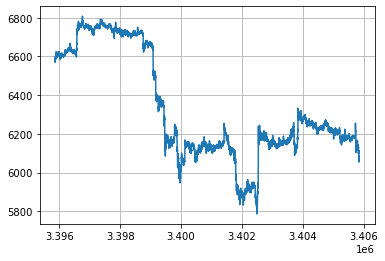

In [6]:
valid_df.close.plot(grid=True)

## Build Environment

Half (or more) of the work to do rl in real life is to formulate the environment to fit the objective.
* `Obj` ของตัวอย่างนี้ ค่อนข้างที่จะไม่สมจริง (แต่เหมาะสมสำหรับการศึกษา)
* `Obj.` คือการที่ agent ได้รับ highest returns in any given 10-hour window.
* We assume 0.5% commission (you need to pay a small fee to change your position) and 0% risk-free rate (the safest alternative asset you can invest other than Bitcoin has 0% returns).

The class SingleStockEnvironment below is given as a guideline for an environment that comply with our objective. Some tips for implementation:
* Think about what the agent should know to make a decision and include all of those as a state such as technical indicators, previous actions, and so on.
* Reward should be aligned with the objective.
* Bonus Obviously this environment is unrealistic with risk-free rate and only one asset. What can you do to make it more realistic?

In [39]:
# import numpy as np
# import pandas as pd

# class SingleStockEnvironment:
#     def __init__(self, df, episode_len = 600, short_window = 15, long_window = 60,
#                 state_cols = ['hodl','close_change','short','long','signal'], commission=0.0005):
#         '''
#         Default:
#             * take input `df` which has at least `timestamp` and `close`
#             * 0.05% commission; risk free rate of 0%
#             * benchmark with buy and HODL and momentum strategies only
#         '''
#         self.episode_len = 600
#         self.short_window = short_window
#         self.long_window = long_window
#         self.master_df = self.process_df(df.copy())
#         self.state_cols = state_cols
#         self.actions = [-1,0,1]
#         self.commission = commission
#         self.reset()
        
#     def reset(self):
#         '''
#         Fill in the blank
#         Sample a data frame with episode length `self.episode_len` from `self.master_df`
#         return current state as a numpy array
#         ''' 
#         self.idx = 0
#         self.previous_action = 0
#         rand_idx = np.random.randint(0,self.master_df.shape[0]-self.episode_len)
#         self.df = self.master_df.copy().iloc[rand_idx:(rand_idx+self.episode_len),:].reset_index(drop=True)
#         return self.get_state()
    
#     def step(self, action_idx):
#         '''
#         Fill in the black
#         Default: take either `long` (1), `do nothing` (0) or `short` (-1) as action
#         Possible: include `do nothing` (0) as liquidating all existing positions, especially
#         interesting when taking into account commmissions
        
#         Input: action_idx (don't forget to record it to `self.df`)
#         Output: next state, reward, done, info (can be any useful information)
#         '''
#         #record action
#         self.df.iloc[self.idx,self.df.columns.get_loc('signal')] = self.actions[action_idx]
        
#         #record commission, if any
#         if self.previous_action==0 and self.actions[action_idx]!=0: #change from nothing to position
#             self.df.iloc[self.idx,self.df.columns.get_loc('commission')] = self.commission
#         elif self.previous_action!=self.actions[action_idx] and self.previous_action!=0: #change from position to another position
#             self.df.iloc[self.idx,self.df.columns.get_loc('commission')] = self.commission*2
#         self.previous_action = self.actions[action_idx]
        
#         #reward
#         reward = self.get_reward()
        
#         #done
#         done=False
#         if self.idx == self.df.index.max()-1: done=True
        
#         #info
#         info = {'idx':self.idx, 
#                 'reward': reward,
#                 'model returns': ((self.df.close_returns[:self.idx]+self.df.commission[:self.idx]) * self.df.signal[:self.idx] + 1).prod(),
#                 'HODL returns': (1+self.df.close_returns[:self.idx]).prod(),
#                 'SHORTL returns': (1-self.df.close_returns[:self.idx]).prod(),
#                 'mom returns': (self.df.close_returns[:self.idx] * self.df.mom_signal[:self.idx] + 1).prod()}
        
#         #increment idx
#         self.idx+=1

#         return self.get_state(),reward,done, info
        
#     def get_state(self):
#         '''
#         Fill in the blank
#         Default: [HODL portfolio (from first period), close price change from last period, 
#         short indicator, long indicator]
#         Possible: indicators, previous timesteps
#         '''
#         return np.array(self.df.loc[self.idx,self.state_cols])
    
#     def get_reward(self):
#         '''
#         Fill in the blank
#         Default: returns of close price 
#         Possible: sharpe ratio, sortino ratio, change in portfolio etc.
#         '''
#         rewards = ((self.df.close_returns+self.df.commission)*self.df.signal+1).cumprod().diff()
# #         rewards = self.df.close_returns * self.df.signal
#         return np.round(np.nan_to_num(rewards[self.idx])*1000,6)
# #         return 1 if rewards[self.idx] > 0 else -1
        
#     def process_df(self,df):
#         #minimal features
#         df['close_change'] = df.close.pct_change()
#         df.fillna(0, inplace=True)
#         df['hodl'] = (df.close_change+1).cumprod()
#         #momentum features
#         df['short'] = df.hodl.rolling(window=self.short_window, min_periods=1, center=False).mean()
#         # df['short'] = df.hodl.ewm(span=self.short_window, min_periods=1).mean()
#         df['long'] = df.hodl.rolling(window=self.long_window, min_periods=1, center=False).mean()
#         # df['long'] = df.hodl.ewm(span=self.long_window, min_periods=1).mean()
#         df['mom_signal'] = 0
#         df.iloc[self.short_window:,df.columns.get_loc('mom_signal')] = np.where(df['short'][self.short_window:] > df['long'][self.short_window:], 1, -1)
#         #returns
#         df['close_returns'] = df.close_change.shift(-1)
#         df['signal'] = 0
#         df['commission'] = 0
#         return df

## Build Memory
Create a memory to store transitions and feed to the agent.

In [7]:
# class VanillaMemory:
#     def __init__(self, memory_size):
#         self.memory_size = memory_size
#         self.memory = deque(maxlen=memory_size) 
#     def add(self, *args):
#         pass
#     def sample(self, batch_size):
#         pass
#     def __len__(self):
#         return len(self.memory)

In [2]:
from solutions.memories import PrioritizedNStepMemory

## Build Nework
Create an architecture tempalte for the networks to use to estimate action and/or state values. You can go crazy with convolutions, recurrent networks or transformers.

In [3]:
from solutions.networks import NoisyDuelingNetwork

In [8]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# class DenseNetwork(models.Model):
#     def __init__(self, output_size, hidden_sizes, **args):
#         super(DenseNetwork, self).__init__()
#         pass
#     def call(self, x, training=True):
#         pass

## Build Agent

In [4]:
from solutions.agents import DQNAgent

In [9]:
# class DQNAgent:
#     def __init__(self, state_size, action_size, replay_memory,
#         lr=1e-3, bs = 64, clip=1., hidden_sizes = [256,256],
#         gamma=0.99, tau= 1e-3, update_interval = 5, update_times = 1,
#         double = False, Architecture=DenseNetwork):
        
#         self.state_size = state_size
#         self.action_size = action_size
#         self.hidden_sizes = hidden_sizes
#         self.lr = lr
#         self.bs = bs
#         self.gamma = gamma
#         self.update_interval = update_interval
#         self.update_times = update_times
#         self.tau = tau
#         self.losses = []
#         self.clip = clip
#         self.double = double
#         self.Architecture = Architecture

#         #networks
#         self.network_local = Architecture(output_size=self.action_size, 
#                                           hidden_sizes = self.hidden_sizes, 
#                                           input_size=state_size)
#         self.network_local.build(input_shape=(None,self.state_size))
#         self.network_target = Architecture(output_size=self.action_size,
#                                            hidden_sizes=self.hidden_sizes,
#                                            input_size=state_size)
#         self.network_target.build(input_shape=(None,self.state_size))
#         self.network_target.set_weights(self.network_local.get_weights())
        
#         #optimizer
#         self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, clipvalue=self.clip)
        
#         # replay memory
#         self.memory = replay_memory
#         # count time steps and episodes
#         self.t_step = 0
#         self.episodes = 0
    
#     def step(self, state, action, reward, next_state, done):
#         #add transition to replay memory
#         self.memory.add(state, action, reward, next_state, done, #for all others
#             self.episodes, self.t_step) #for nstep memory

#         #increment episodes if done
#         if done: 
#             self.t_step = 0
#             self.episodes+=1
        
#         #update target network
#         self.soft_update()
#         #self.hard_update()
        
#         # learn every self.t_step
#         self.t_step += 1
#         if self.t_step % self.update_interval == 0:
#             if len(self.memory) > self.bs:
#                 for _ in range(self.update_times):
#                     if isinstance(self.memory,PrioritizedMemory):
#                         transitions = self.memory.sample(self.bs, self.get_beta(self.episodes))
#                     else:
#                         transitions = self.memory.sample(self.bs)
#                     loss = self.learn(transitions)
#                     self.losses.append(loss)

#     def act(self, state):
#         eps = self.get_eps(self.episodes)
#         action_values = self.network_local(tf.cast(state[None,:],dtype=tf.float32))
#         print(action_values)
#         print(type(action_values))
#         #epsilon greedy exploration
#         if random.random() > eps:
#             return np.argmax(action_values.numpy())
#         else:
#             return random.choice(np.arange(self.action_size))

#     #we use tf.function decorator for training process to switch from eager to static graph
#     #NOT compatible with PrioritizedMemory yet
#     #with decorator
#     #1.64 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     #without decorator
#     #2.93 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# #     @tf.function
#     def learn(self, transitions):
#         states, actions, rewards, next_states, dones = transitions

#         if self.double:
#             max_actions_next = tf.cast(tf.argmax(self.network_local(next_states),1), dtype=tf.int32)
#             seq = tf.range(0, actions.shape[0])
#             max_action_idxs = tf.transpose(tf.stack([seq, max_actions_next]))
#             q_targets_next = tf.gather_nd(self.network_target(next_states), max_action_idxs)[:,tf.newaxis]
#         else:
#             q_targets_next = tf.reduce_max(self.network_target(next_states),1)[:,tf.newaxis]

#         q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)
#         q_targets = q_targets[:,0] #flatten q_targets

#         with tf.GradientTape() as tape:
#             #get predictions of all actions
#             preds = self.network_local(states)
            
#             #get index of actions used to calculate q_expected
#             actions = actions[:,0] #flatten actions
#             seq = tf.range(0, actions.shape[0])
#             action_idxs = tf.transpose(tf.stack([seq, actions]))

#             #get q values only at specific action indice
#             #tensorflow has this weird way to gather where you need to put index as
#             #[[0, action_idx1],[1, action_idx2],...,[n, action_idxn]]
#             q_expected = tf.gather_nd(preds, action_idxs)
            
#             #calculate loss
#             loss = self.vanilla_loss(q_targets, q_expected)
            
#             #get gradients
#             gradients = tape.gradient(loss, self.network_local.trainable_weights)
        
#         #apply gradients
#         self.optimizer.apply_gradients(zip(gradients,self.network_local.trainable_weights))

#         return loss

#     def vanilla_loss(self, q_targets, q_expected):
#         return tf.keras.losses.mse(q_targets, q_expected)
    
#     def hard_update(self):
#         if self.t_step % 1/self.tau==0:
#             self.network_target.set_weights(self.network_local.get_weights())

#     def soft_update(self):
#         weights_local = np.array(self.network_local.get_weights())
#         weights_target = np.array(self.network_target.get_weights())
#         self.network_target.set_weights(self.tau * weights_local + (1 - self.tau) * weights_target)
        
#     def get_eps(self, i, eps_start = 1., eps_end = 0.001, eps_decay = 0.9):
#         eps = max(eps_start * (eps_decay ** i), eps_end)
#         return(eps)

In [5]:
import gym
env = gym.make('CartPole-v1')

In [6]:
# from solutions1.memories import VanillaMemory
# from solutions1.agents import DQNAgent

# mem = VanillaMemory(int(1e5)) 
mem = PrioritizedNStepMemory(int(1e5))


# a = DQNAgent(state_size = env.reset().shape[0], 
#              action_size = env.action_space.n, replay_memory = mem,
#              hidden_sizes=[64,64], double=True)

a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [64,64],
             action_size = env.action_space.n, replay_memory = mem,
             double=True, Architecture=NoisyDuelingNetwork)

In [7]:
import random
import numpy as np

scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
solved_score=100

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    actions = []
    while True:
        #select action
        action = a.act(state)  
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #agent step
        a.step(state,action,reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))

    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i} with moving average of {moving_scores[-1]}')
        break

Episdoe 99 Moving Average: 9.323232323232324
Episdoe 199 Moving Average: 9.39
Episdoe 299 Moving Average: 9.4
Episdoe 399 Moving Average: 9.36
Episdoe 499 Moving Average: 9.42
Episdoe 599 Moving Average: 9.33
Episdoe 699 Moving Average: 9.44
Episdoe 799 Moving Average: 9.45
Episdoe 899 Moving Average: 9.35
Episdoe 999 Moving Average: 9.37
Episdoe 1099 Moving Average: 9.34
Episdoe 1199 Moving Average: 9.4
Episdoe 1299 Moving Average: 9.36
Episdoe 1399 Moving Average: 9.33
Episdoe 1499 Moving Average: 9.41
Episdoe 1599 Moving Average: 9.3
Episdoe 1699 Moving Average: 9.34
Episdoe 1799 Moving Average: 9.4
Episdoe 1899 Moving Average: 9.48
Episdoe 1999 Moving Average: 9.38
Episdoe 2099 Moving Average: 9.35
Episdoe 2199 Moving Average: 9.34
Episdoe 2299 Moving Average: 9.27
Episdoe 2399 Moving Average: 9.3
Episdoe 2499 Moving Average: 9.25
Episdoe 2599 Moving Average: 9.43
Episdoe 2699 Moving Average: 9.41
Episdoe 2799 Moving Average: 9.3
Episdoe 2899 Moving Average: 9.23
Episdoe 2999 Movin

OverflowError: (34, 'Result too large')

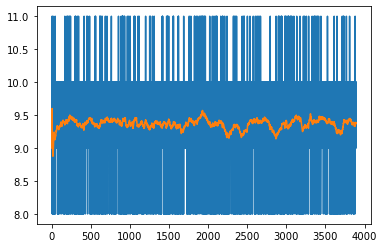

In [8]:
plt.plot(scores)
plt.plot(moving_scores)

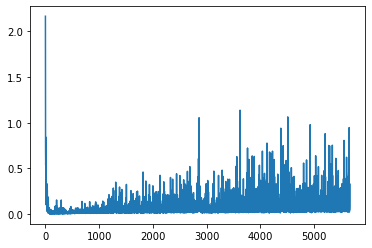

In [9]:
plt.plot(a.losses)